In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import gradient_boosting
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

from nb18 import ltv_with_cupons

In [2]:
transactions, customer_features = ltv_with_cupons()

print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,0,0,0,0,1,0,0,3,...,0,0,0,10,0,0,0,0,0,0
1,1,-61,0,2,3,0,0,0,0,2,...,0,2,0,0,0,31,0,0,0,0
2,2,-8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-41,0,0,0,22,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print(customer_features.shape)
customer_features.head()

(10000, 5)


,customer_id,region,income,cupons,age
0,0,1,1025,5,24
1,1,49,1649,5,26
2,2,7,2034,15,33
3,3,29,1859,15,35
4,4,0,1243,5,26


In [4]:
def process_data(transactions, customer_data):

    profitable = (transactions[["customer_id"]]
                  .assign(net_value = transactions
                          .drop(columns="customer_id")
                          .sum(axis=1)))

    return (customer_data
            .merge(profitable, on="customer_id")
            ## include the cupons cost
            .assign(net_value = lambda d: d["net_value"] - d["cupons"]))

customer_features = process_data(transactions, customer_features)
customer_features.head()

,customer_id,region,income,cupons,age,net_value
0,0,1,1025,5,24,-100
1,1,49,1649,5,26,-16
2,2,7,2034,15,33,18
3,3,29,1859,15,35,-45
4,4,0,1243,5,26,-18


In [5]:
customer_features.groupby("cupons")["customer_id"].count()

cupons
0      458
5     4749
10    4154
15     639
Name: customer_id, dtype: int64

In [6]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)
train.shape, test.shape

((7000, 6), (3000, 6))

## Simple Policy

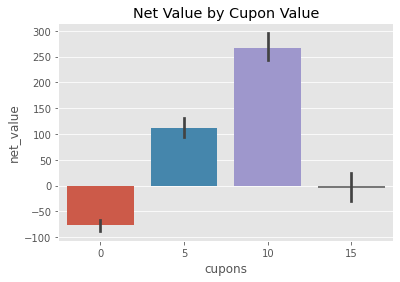

In [7]:
sns.barplot(data=train, x="cupons", y="net_value")
plt.title("Net Value by Cupon Value");

In [8]:
simple_policy = 10 * np.ones(customer_features["cupons"].shape)

transactions_simple_policy, customer_features_simple_policy = ltv_with_cupons(simple_policy)

customer_features_simple_policy = process_data(transactions_simple_policy,
                                               customer_features_simple_policy)

customer_features_simple_policy.head()

,customer_id,region,income,cupons,age,net_value
0,0,1,1025,10,24,17
1,1,49,1649,10,26,142
2,2,7,2034,10,33,9
3,3,29,1859,10,35,-40
4,4,0,1243,10,26,32


In [9]:
simple_policy_gain = customer_features_simple_policy["net_value"].mean()
simple_policy_gain

464.556

## Policy With Model

In [10]:
def model_bands(train_set, features, target, model_params, n_bands, seed=1):
    
    np.random.seed(seed)
    
    reg = ensemble.GradientBoostingRegressor(**model_params)
    reg.fit(train_set[features], train_set[target])
    
    bands = pd.qcut(reg.predict(train_set[features]), q=n_bands, retbins=True)[1]
    
    def predict_bands(test_set):
        predictions = reg.predict(test_set[features])
        pred_bands = np.digitize(predictions, bands) 
        return test_set.assign(predictions=predictions, pred_bands=pred_bands)
    
    return predict_bands

In [11]:
model_params = {'n_estimators': 150,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

model = model_bands(train, features, target, model_params, n_bands=10)

In [12]:
print("Train Score:, ", r2_score(train["net_value"], model(train)["predictions"]))
print("Test Score:, ", r2_score(test["net_value"], model(test)["predictions"]))

Train Score:,  0.3528138363678007
Test Score:,  0.3501181146646303


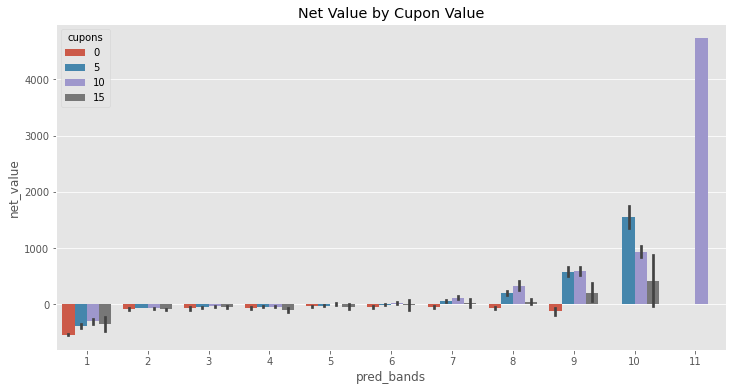

In [13]:
plt.figure(figsize=(12,6))
sns.barplot(data=model(train), x="pred_bands", y="net_value", hue="cupons")
plt.title("Net Value by Cupon Value");

In [14]:
pred_bands = (model(customer_features)
              .groupby(["pred_bands", "cupons"])
              [["net_value"]].mean()
              .reset_index())

pred_bands.head(7)

,pred_bands,cupons,net_value
0,1,0,-542.000000
1,1,5,-383.008197
2,1,10,-317.536842
3,1,15,-353.083333
4,2,0,-74.223529
5,2,5,-69.201274
6,2,10,-72.454416


In [15]:
pred_bands["max_net"] = (pred_bands
                         .sort_values(['net_value'],  ascending=False)
                         .groupby(['pred_bands'])
                         .cumcount() + 1)


pred_bands.head(8)

,pred_bands,cupons,net_value,max_net
0,1,0,-542.000000,4
1,1,5,-383.008197,3
2,1,10,-317.536842,1
3,1,15,-353.083333,2
4,2,0,-74.223529,3
5,2,5,-69.201274,1
6,2,10,-72.454416,2
7,2,15,-88.025641,4


In [16]:
best_cupons_per_band = pred_bands.query("max_net==1")[["pred_bands", "cupons"]]

best_cupons_per_band

,pred_bands,cupons
2,1,10
5,2,5
10,3,10
13,4,5
18,5,10
22,6,10
26,7,10
30,8,10
34,9,10
37,10,5


In [17]:
cupons_per_id = (model(customer_features)
                 .drop(columns=["cupons"])
                 .merge(best_cupons_per_band, on="pred_bands")
                 [["customer_id", "cupons"]])

np.random.seed(1)
cupons_per_id.sample(7)

,customer_id,cupons
9953,8196,10
3850,1443,10
4962,2636,10
3886,1936,10
5437,6834,10
8517,8180,5
2041,3401,10


In [18]:
transactions_policy_w_model, customer_features_policy_w_model = ltv_with_cupons(
    cupons_per_id[["cupons"]].values.flatten()
)

customer_features_policy_w_model = process_data(transactions_policy_w_model,
                                                customer_features_policy_w_model)

policy_w_model_gain = customer_features_policy_w_model["net_value"].mean()
policy_w_model_gain

209.973

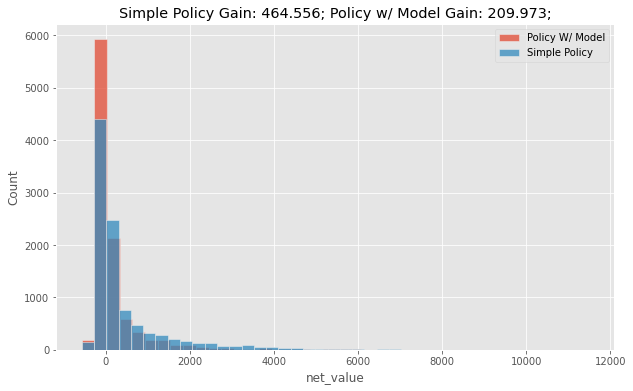

In [19]:
plt.figure(figsize=(10,6))
sns.histplot(data=customer_features_policy_w_model, bins=40,
             x="net_value", label="Policy W/ Model", color="C0")
sns.histplot(data=customer_features_simple_policy, bins=40,
             x="net_value", label="Simple Policy", color="C1")
plt.legend()
plt.title(f"Simple Policy Gain: {simple_policy_gain}; Policy w/ Model Gain: {policy_w_model_gain};");